# Data Integrity Check


Comparison between python extracted data vs matlab extracted data.

In [8]:
# Relevant imports

import os
import pandas as pd
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter
import seaborn as sns

In [22]:
# Pulling python dataframe 

df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_fibrosis.head(10)

df_processed = df_fibrosis

In [10]:
# Pulling matlab dataframe 

df_matlab = pd.read_excel('outputCSV.xlsx')
df_matlab = df_matlab.drop(columns=['class1','class2', 'class3', 'class4', 'class5'])
df_matlab.tail(10)

,filename,class0
3039,211_4647_0021,0
3040,211_4647_0022,0
3041,211_4647_0023,0
3042,211_4647_0024,0
3043,211_4647_0025,0
3044,211_4647_0026,0
3045,211_4647_0027,0
3046,211_4647_0028,0
3047,211_4647_0029,0
3048,211_4647_0030,0


# Preliminary Analysis

I won't be performing any type of specific statystical analysis here, since features will be derived by CNN. Instead, I will be focusing on normalization and augmentation, with the intent of enhancing algortihm performance.

In [11]:
# General overview
print("\nGeneral overview:")
df_fibrosis.info()


General overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SliceID    3075 non-null   object
 1   SliceData  3075 non-null   object
 2   Class      3075 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 72.2+ KB


In [12]:
# General overview
print("\nGeneral overview:")
df_matlab.info()


General overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3049 non-null   object
 1   class0    3049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.8+ KB


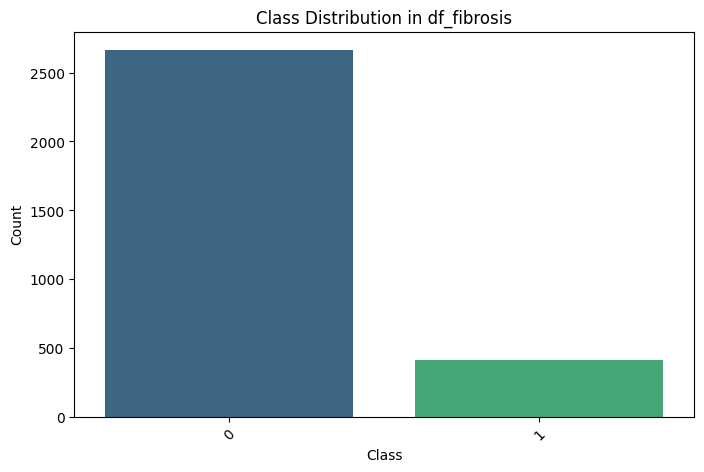

Class
0    86.699187
1    13.300813
Name: count, dtype: float64
Class
0    2666
1     409
Name: count, dtype: int64


In [13]:
# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_fibrosis, x='Class', hue="Class", palette='viridis', legend=False)

plt.title('Class Distribution in df_fibrosis')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_fibrosis['Class'].value_counts(), len(df_fibrosis)
print((class_counts / total_samples) * 100)
print(class_counts)

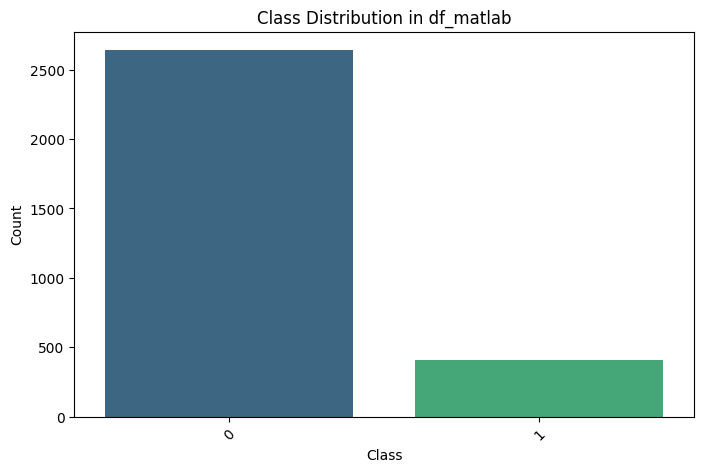

class0
0    86.651361
1    13.348639
Name: count, dtype: float64
class0
0    2642
1     407
Name: count, dtype: int64


In [14]:
# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_matlab, x='class0', hue="class0", palette='viridis', legend=False)

plt.title('Class Distribution in df_matlab')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_matlab['class0'].value_counts(), len(df_matlab)
print((class_counts / total_samples) * 100)
print(class_counts)

### <span style="color: green">Datasets are consistent!!!</span>

## HRCT

It is also important to verify if the predefined test split shares the same data proportion, for result validity:

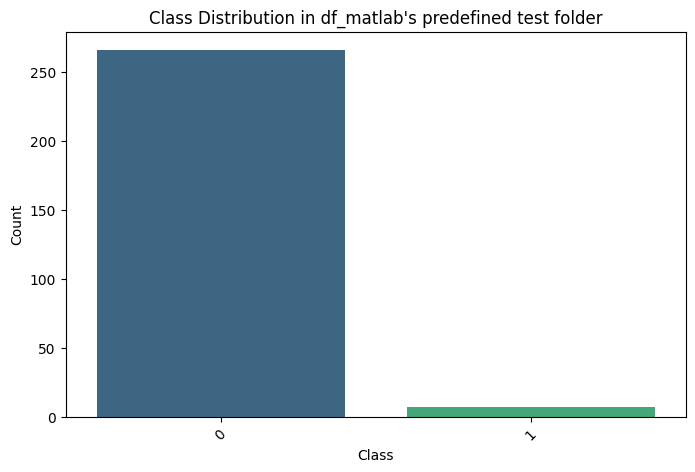

class0
0    97.435897
1     2.564103
Name: count, dtype: float64
class0
0    266
1      7
Name: count, dtype: int64


In [15]:
# Plots class counts
df_fibrosis_test = df_matlab.iloc[2776:3051]

plt.figure(figsize=(8, 5))
sns.countplot(data=df_fibrosis_test, x='class0', hue="class0", palette='viridis', legend=False)

plt.title('Class Distribution in df_matlab\'s predefined test folder')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_fibrosis_test['class0'].value_counts(), len(df_fibrosis_test)
print((class_counts / total_samples) * 100)
print(class_counts)

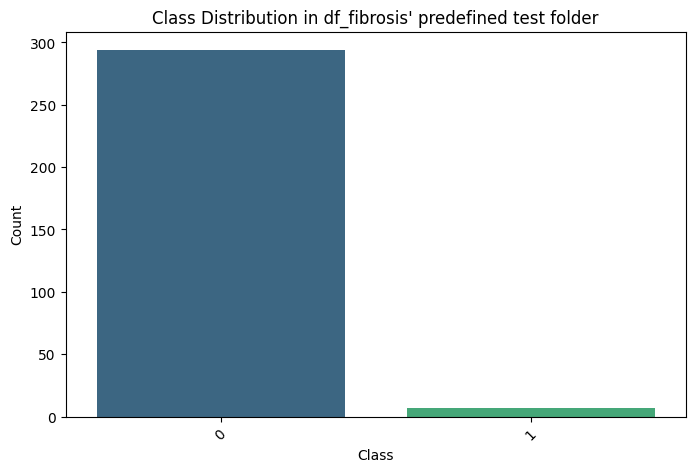

Class
0    97.674419
1     2.325581
Name: count, dtype: float64
Class
0    294
1      7
Name: count, dtype: int64


In [16]:
df_fibrosis_test = df_fibrosis[df_fibrosis["SliceID"].str.contains("HRCT_Pilot")]

# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_fibrosis_test, x='Class', hue="Class", palette='viridis', legend=False)

plt.title('Class Distribution in df_fibrosis\' predefined test folder')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_fibrosis_test['Class'].value_counts(), len(df_fibrosis_test)
print((class_counts / total_samples) * 100)
print(class_counts)

### <span style="color: green">Datasets are consistent!!!</span>

## Normalization 




During ResNet preparations, while checking if the transformation to tensor was correct, I identified a case I hadn't seen before: not all numpy arrays have the same (512,512) shape.

Identifying these cases now is important for consistency of results when implementing my own CNN, so they should all be normalized before model development.

In [17]:
error_list = []

for i in range(len(df_fibrosis)):
    np_shape = df_fibrosis["SliceData"].iloc[i].shape
    if np_shape != (512, 512): error_list.append((np_shape,df_fibrosis["SliceID"].iloc[i]))

print("Number of slices with shape != (512, 512): ",len(error_list))

ctr = 0
for _shape, _id in error_list:
    if _shape != (768, 768): 
        print(_id,": Shape is not (768, 768).")
        ctr += 1
if ctr == 0: print("All shapes are either 512 or 768.")

Number of slices with shape != (512, 512):  70
All shapes are either 512 or 768.


## Augmentation Methods

Choosing data augmentation methods can be challenging, especially when it is usually determined by the type, format and nature of the data in question. It's important that I choose implementations that will allow for the data to retain important details sufficiently well, while generating images that introduce uncertainty, noise and meaningful transformations.

This will most likely force the model to be more robust to generalization of data, as well as increase the number of training examples.

In order to choose the best augmentation methods, I decided to follow results obtained in ["Goceri, E. Medical image data augmentation: techniques, comparisons and interpretations. Artif Intell Rev 56, 12561–12605 (2023)"](https://doi.org/10.1007/s10462-023-10453-z), as the paper evaluates various performance metrics of different methods on a variety of medical image datasets, including lung CT scans.

Based on ammount of generated examples, as well as positive impact in classification, I have decided to explore:


 - **Translation + Shearing:** Could be destructive, in the sense that fibrosis region could be removed/hidden. On the other hand, since examples are created as independent and don't change the original slice data, that could be overlooked as long as AI classifies as not fibrosis if it can't see it. **10x data**.
 - **Translation + Shearing + Rotation:** Same as before, adds another layer of change due to rotation, could affect performance, improve generalization. However, I should be careful not to generate too many examples of the same slice. In order to solve that, I will create independent subsamples of my data in order to apply each method. **10x data**.
 - **Gaussian Noise:** Adds distortion that follows a subsample of the Gaussian Distribution. **3x data**.
 - **Gaussian Noise + Rotation:** Same as the previous topic, adds rotation for generalization purposes. **30x data**.

All of these transformations will be applied to np_arrays, so if the CNN model takes tensors as input, Albumentations must be applied before conversion.

## Visualizing and Experimentation

The chapter below is dedicated to identifying the best combination of settings, regarding my dataset and the available literature.

In [30]:
# Transformation visualizer
def showTransform(transform, random_slice = False):        
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    # Raw image
    if random_slice:
        i = random.choice(range(len(df_processed)))
        example = (df_processed["SliceData"].iloc[i])
        title = "Slice Randomizer"
    else:
        example = df_processed[df_processed["SliceID"] == "7__CT-7771-0012"]["SliceData"].values[0]
        title = "Slice used throughout notebook"

    # Gaussian exceptions

    if transform == "Gauss_noise": modded_example = example + np.random.normal(loc=0, scale=50, size=example.shape)
    elif transform == "Gauss_blur": modded_example = gaussian_filter(example, sigma=(random.choice(range(10,16))/10))    
    else: modded_example = transform(image=example) 

    plt.suptitle(title, fontsize=16)

    axes[0].imshow(example, cmap='gray')
    axes[0].set_title("Original DICOM Image")
    axes[0].axis("off")

    if not ((transform == "Gauss_noise") or (transform == "Gauss_blur")): axes[1].imshow(modded_example["image"], cmap='gray')
    else: axes[1].imshow(modded_example, cmap='gray')
    axes[1].set_title("NumPy Array Representation")
    axes[1].axis("off")

All of the commented codes portray methods for guarantee of transformation, which will not be used in this case.

### Rotation

In [69]:
import albumentations as A

In [70]:
# Rotates in range [30,359]
'''
transform = A.Rotate(limit=random.choice(([30,350],[-350,-30])),
                     p=1)'''

transform = A.Rotate(limit=(-350,30),p=1)
t1 = transform

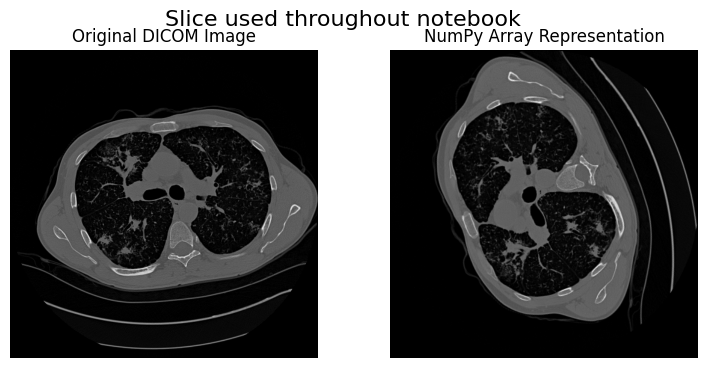

In [71]:
showTransform(transform)

### Translation

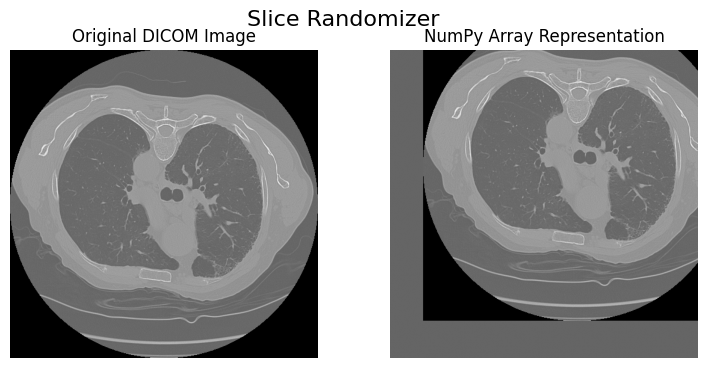

In [72]:
# Applies Translation (specific interval guarantees translation)
# Avoids non-translation when close to 0, while including negative 
'''
transform = A.Affine(translate_percent={"x":random.choice(([-0.15,-0.05],[0.05,0.15])), 
                                        "y":random.choice(([-0.23,-0.05], [0.05,0.25]))},
                    rotate=0,
                    scale=1,
                    p=1)
'''

transform = A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}}, rotate=0, scale=1, p=1)

t2 = transform

showTransform(transform, True)

### Shearing

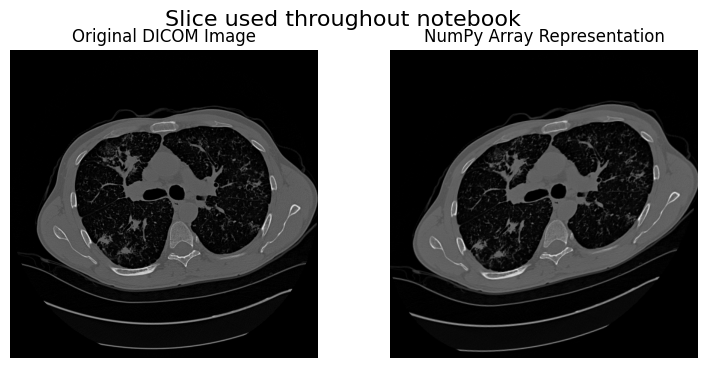

In [73]:
# Applies Shearing (specific positive interval guarantees shearing)
'''
transform = A.Affine(shear={
    # Avoids non-shearing when close to 0
    # while including negative 
    "x":random.choice(([5,15],[-15,-5])), "y":random.choice(([5,15],[-15,-5]))},p=1)
'''

transform = A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=1)

t3 = transform

showTransform(transform)

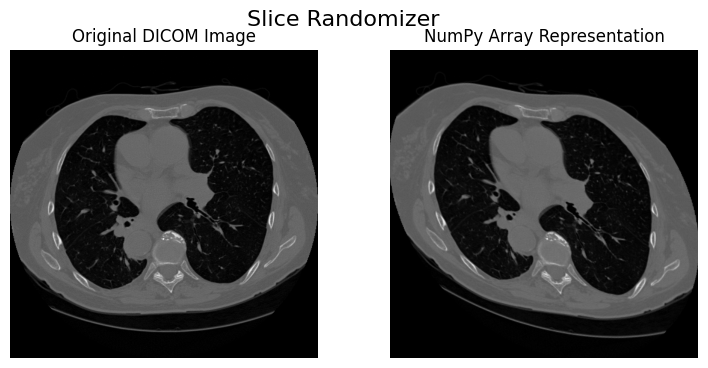

In [74]:
# Applies Shearing (specific interval guarantees shearing)
transform = A.Affine(shear={
    # Avoids non-shearing when close to 0
    # while including negative 
    "x":random.choice(([5,15],[-15,-5])), "y":random.choice(([5,15],[-15,-5]))},p=1)

t3 = transform

showTransform(transform, True)



### Gaussian Noise

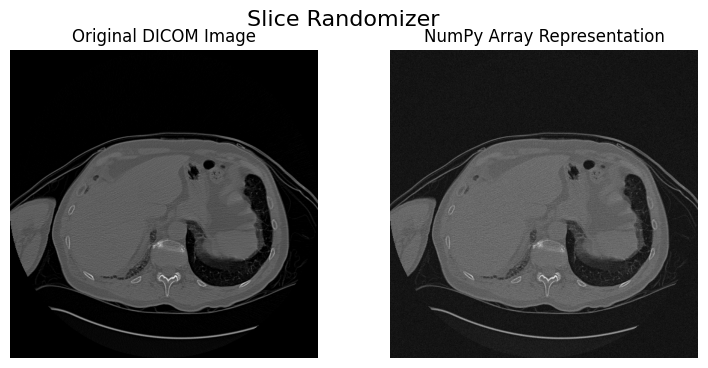

In [75]:
# Applies Gaussian Noise
transform = "Gauss_noise"

t4 = transform

showTransform(transform, True)

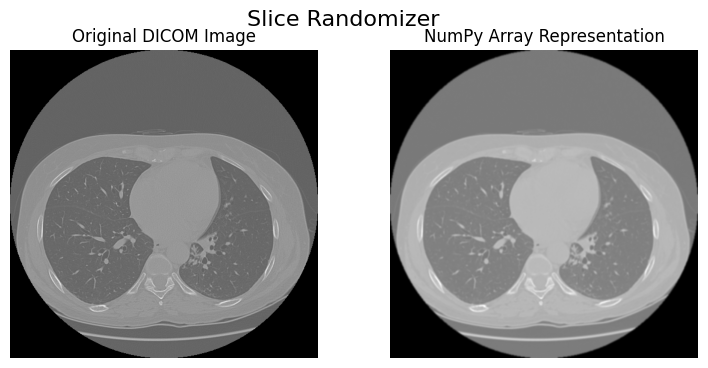

In [76]:
# Applies Gaussian Blur
transform = "Gauss_blur"

t5 = transform

showTransform(transform, True)

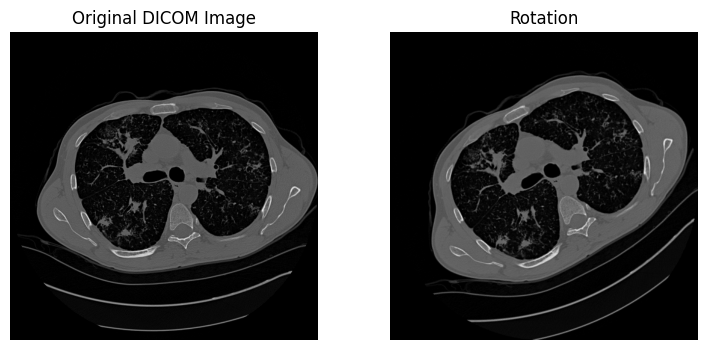

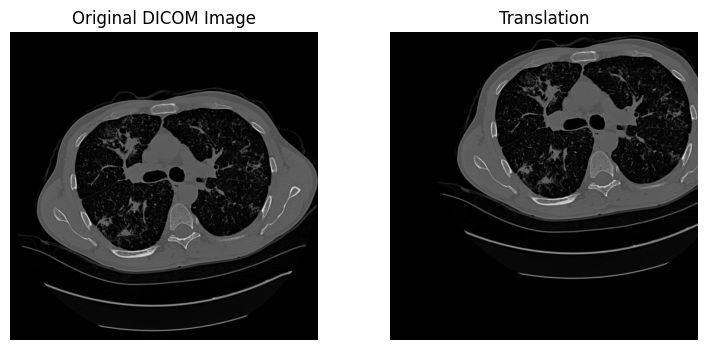

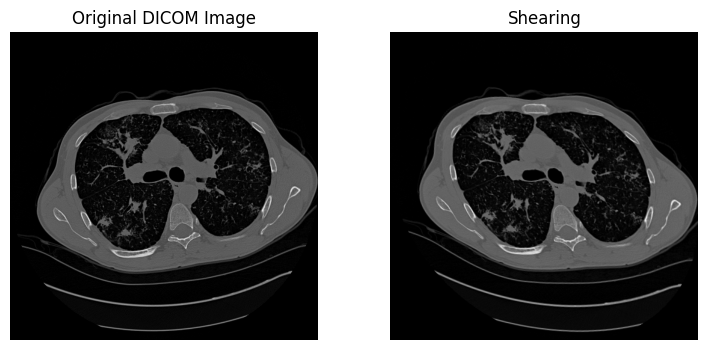

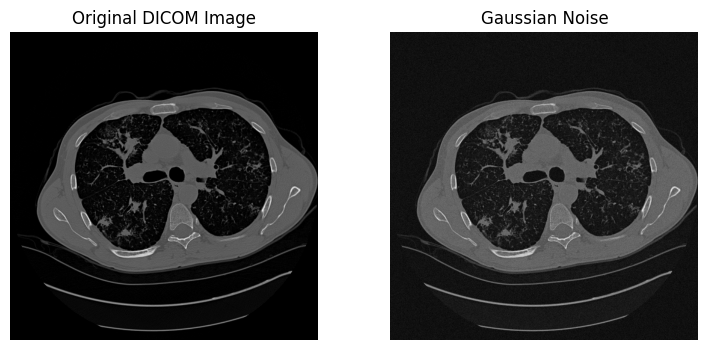

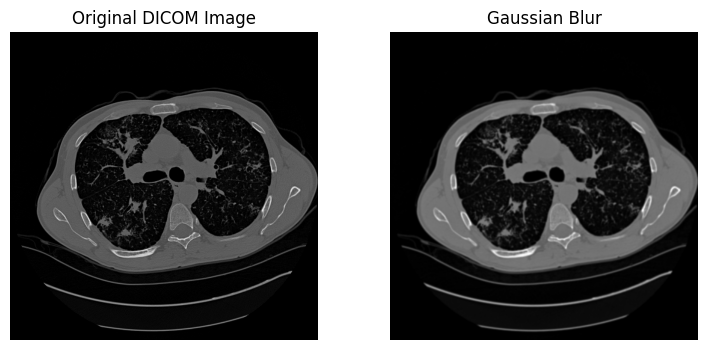

In [ ]:
names = ["Rotation", "Translation", "Shearing", "Gaussian Noise", "Gaussian Blur"]
transforms = [t1,t2,t3,t4,t5]
for t in range(len(transforms)):
    showTransformN(transforms[t], names[t])

In [ ]:
# Transformation visualizer
def showTransformN(transform, ttl):        
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    example = df_processed[df_processed["SliceID"] == "7__CT-7771-0012"]["SliceData"].values[0]

    # Gaussian exceptions

    if transform == "Gauss_noise": modded_example = example + np.random.normal(loc=0, scale=50, size=example.shape)
    elif transform == "Gauss_blur": modded_example = gaussian_filter(example, sigma=(random.choice(range(10,16))/10))    
    else: modded_example = transform(image=example) 

    axes[0].imshow(example, cmap='gray')
    axes[0].set_title("Original DICOM Image")
    axes[0].axis("off")

    if not ((transform == "Gauss_noise") or (transform == "Gauss_blur")): axes[1].imshow(modded_example["image"], cmap='gray')
    else: axes[1].imshow(modded_example, cmap='gray')
    axes[1].set_title(ttl)
    axes[1].axis("off")

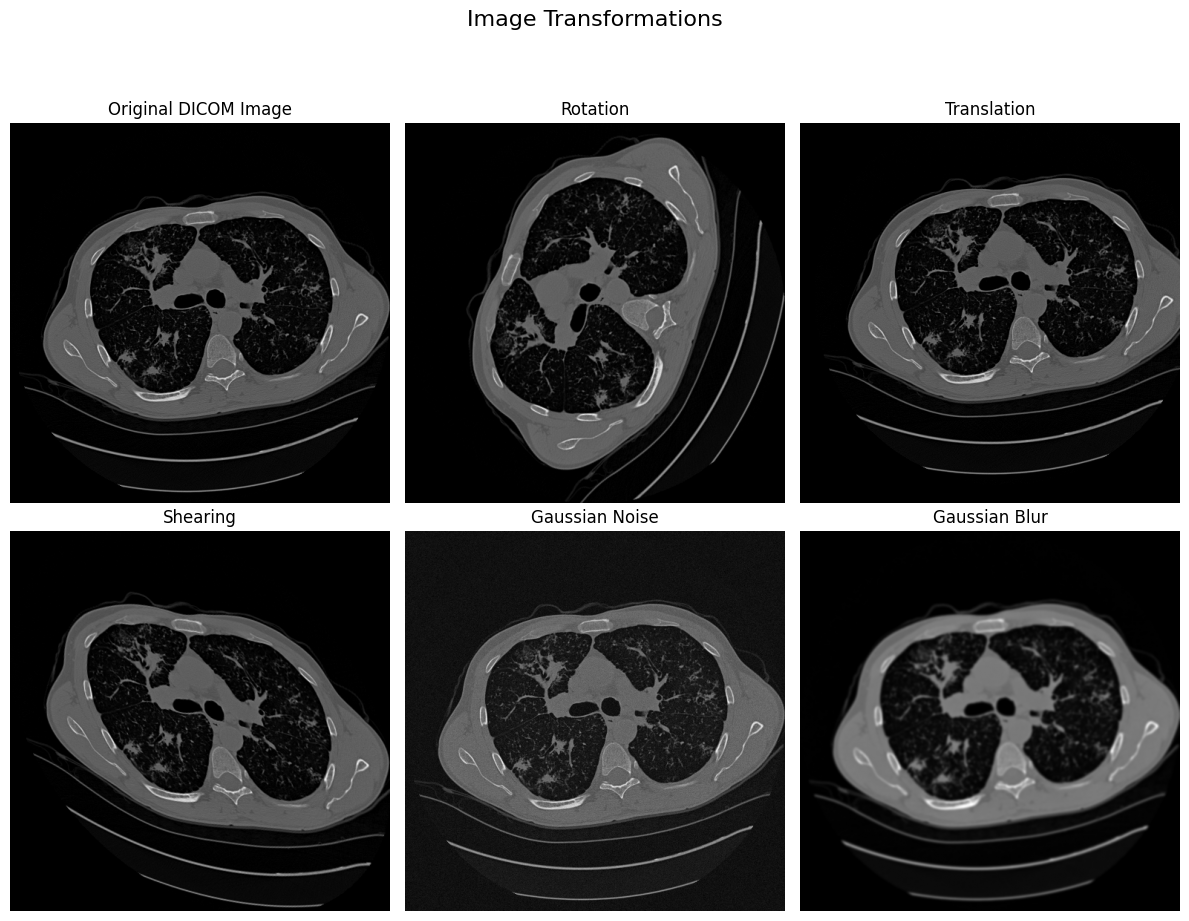

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.ndimage import gaussian_filter

# Your transformation names and functions
names = ["Rotation", "Translation", "Shearing", "Gaussian Noise", "Gaussian Blur"]
transforms = [t1, t2, t3, "Gauss_noise", "Gauss_blur"]

# Load example image
example = df_processed[df_processed["SliceID"] == "7__CT-7771-0012"]["SliceData"].values[0]

# Prepare figure: 2 rows × 3 columns (6 subplots)
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
fig.suptitle("Image Transformations", fontsize=16)

# Plot original image in the first subplot
axes[0, 0].imshow(example, cmap='gray')
axes[0, 0].set_title("Original DICOM Image")
axes[0, 0].axis("off")

# Apply and plot each transformation starting from subplot 1 (index 1)
for i, (transform, name) in enumerate(zip(transforms, names), start=1):
    # Determine subplot position considering the original image at axes[0, 0]
    row = i // 3
    col = i % 3

    # Apply transformation
    if transform == "Gauss_noise":
        modded_example = example + np.random.normal(loc=0, scale=50, size=example.shape)
        img = modded_example
    elif transform == "Gauss_blur":
        sigma = random.choice(range(10, 16)) / 10
        modded_example = gaussian_filter(example, sigma=sigma)
        img = modded_example
    else:
        modded_example = transform(image=example)
        img = modded_example["image"]

    # Plot transformed image
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(name)
    axes[row, col].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


---

## Extra: Manual Confirmation Used For Integrity Confirmation

---

## Python Translation of Matlab Code Implementation 

In [6]:
import os
import re

In [5]:
root = r"C:\Users\hasht\Desktop\Cloned Repositories\fibrosis_dataset\ILD_DB_txtROIs"

In [8]:
def load_roi_files(roi_file_name):
    # List to store all the ROIs
    rois = []

    # Open the ROI file for reading
    with open(roi_file_name, 'r') as file:
        roi = {}
        while True:
            # Read a line from the file
            line = file.readline()
            
            # Stop if we reach the end of the file
            if not line:
                break

            # Check and parse each line based on its prefix
            if 'label:' in line:
                roi['label'] = line.replace('label: ', '').strip()
            elif 'slice_number:' in line:
                roi['slice_number'] = float(line.replace('slice_number: ', '').strip())

                # Append the parsed ROI to the list of ROIs
                rois.append(roi)
                roi = {}  # Reset for the next ROI

    return rois

In [30]:
# Recursively search a folder for .txt files and load ROI data from them
def search_and_load_roi_files(folder):
    for root, dirs, files in os.walk(folder):  # Walk through all subdirectories
        folder_name = os.path.basename(root)  # Get the folder name, not the whole directory path
        print(f"Searching in folder: {folder_name}")  # Print the current folder
        
        for file in files:
            if file.endswith(".txt"):  # Check if the file is a .txt file
                txt_file_path = os.path.join(root, file)
                print(f"Found txt file: {file}")  # Print the txt file found
                
                # Load the ROIs for the current txt file
                rois = load_roi_files(txt_file_path)
                print(f"Loaded ROIs from {file}: {rois}")  # Print the loaded ROIs
                print("\n" + "="*50 + "\n")  # Separator for clarity

print(search_and_load_roi_files(root + r'\HRCT_pilot'))

Searching in folder: HRCT_pilot
Searching in folder: 200
Found txt file: CT-0002.txt
Loaded ROIs from CT-0002.txt: [{'label': 'healthy', 'slice_number': 5.0}, {'slice_number': 9.0}, {'slice_number': 12.0}, {'slice_number': 15.0}]


Searching in folder: 201
Found txt file: CT-0002.txt
Loaded ROIs from CT-0002.txt: [{'label': 'micronodules', 'slice_number': 5.0}, {'slice_number': 9.0}, {'slice_number': 15.0}]


Searching in folder: 203
Found txt file: CT-7800.txt
Loaded ROIs from CT-7800.txt: [{'label': 'healthy', 'slice_number': 10.0}, {'label': 'fibrosis', 'slice_number': 15.0}, {'slice_number': 17.0}]


Searching in folder: 204
Found txt file: CT-3962.txt
Loaded ROIs from CT-3962.txt: [{'label': 'healthy', 'slice_number': 7.0}, {'slice_number': 13.0}, {'slice_number': 17.0}, {'slice_number': 18.0}, {'slice_number': 22.0}, {'slice_number': 23.0}, {'label': 'bronchiectasis', 'slice_number': 17.0}, {'slice_number': 18.0}]


Searching in folder: 205
Found txt file: CT-0002.txt
Loaded ROIs

In [ ]:
def search_and_load_roi_files(folder):
    target_labels = {"early_fibrosis", "bronchiectasis", "reticulation"}

    for root, dirs, files in os.walk(folder):
        folder_name = os.path.basename(root)

        for file in files:
            if file.endswith(".txt"):
                txt_file_path = os.path.join(root, file)

                rois = load_roi_files(txt_file_path)

                # Check if the first ROI has a target label
                if rois and isinstance(rois[0], dict):
                    label = rois[0].get('label', None)
                    if label in target_labels:
                        print(f"Searching in folder: {folder_name}")
                        print(f"{file}")
                        print('\n')
                        for dicts in rois: print(dicts)
                        print("\n" + "="*50 + "\n")
                        print('\n')


In [22]:
search_and_load_roi_files(root)

Searching in folder: 107
CT-INSPIRIUM-3684.txt
{'label': 'reticulation', 'slice_number': 12.0}
{'slice_number': 13.0}
{'slice_number': 14.0}
{'slice_number': 15.0}
{'slice_number': 16.0}
{'slice_number': 17.0}
{'slice_number': 18.0}
{'slice_number': 19.0}
{'label': 'ground_glass', 'slice_number': 11.0}
{'slice_number': 12.0}
{'slice_number': 15.0}




Searching in folder: 108
CT-INSPIRIUM-6415.txt
{'label': 'reticulation', 'slice_number': 18.0}
{'slice_number': 19.0}
{'slice_number': 20.0}
{'slice_number': 21.0}
{'label': 'ground_glass', 'slice_number': 9.0}
{'slice_number': 10.0}
{'slice_number': 11.0}
{'slice_number': 13.0}




Searching in folder: 128
CT-Thx-HR-1-10-mm-inspiration-0007.txt
{'label': 'reticulation', 'slice_number': 22.0}
{'slice_number': 23.0}
{'slice_number': 24.0}
{'slice_number': 25.0}
{'slice_number': 26.0}
{'slice_number': 29.0}
{'slice_number': 30.0}
{'slice_number': 31.0}
{'slice_number': 32.0}
{'slice_number': 33.0}
{'slice_number': 34.0}
{'slice_number': 35.